In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cascade-cup-22/sample_submission.csv
/kaggle/input/cascade-cup-22/train.csv
/kaggle/input/cascade-cup-22/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

VALID_TRAIN_SPLIT = 0.2
TEST_SPLIT_RATIO  = 0.2
SEED = 42

In [3]:
data_df = pd.read_csv('/kaggle/input/cascade-cup-22/train.csv')
test_df = pd.read_csv('/kaggle/input/cascade-cup-22/test.csv')
print('DATA loaded ...')
print(f'Train Columns : {data_df.shape[1]}   Rows : {data_df.shape[0]}')
print(f'Test Columns : {test_df.shape[1]}   Rows : {test_df.shape[0]}')


DATA loaded ...
Train Columns : 20   Rows : 450000
Test Columns : 16   Rows : 144844


In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        
        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [5]:
data_df = reduce_mem_usage(data_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 68.66 MB
Memory usage after optimization is: 41.20 MB
Decreased by 40.0%
Memory usage of dataframe is 17.68 MB
Memory usage after optimization is: 9.67 MB
Decreased by 45.3%


In [6]:
data_df.head(10)

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.566406,2.650391,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.521484,2.759766,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.267578,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.207031,4.800781,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.820312,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.189453,6.378906,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.531250,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.787109,4.011719,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.349609,NaN
5,2021-01-26 03:07:16,556758,2021-01-26 00:00:00,2021-01-26 03:12:14,2021-01-26 03:12:27,2021-01-26 03:25:36,2021-01-26 03:45:51,1469,2.482422,5.179688,296.0,294.0,0,2.0,1506.0,NaN,NaN,NaN,NaN,NaN
6,2021-01-26 03:10:50,556759,2021-01-26 00:00:00,2021-01-26 03:11:18,2021-01-26 03:12:05,2021-01-26 03:19:31,2021-01-26 03:26:04,8851,2.808594,3.400391,45.0,45.0,0,0.0,1460.0,NaN,NaN,NaN,NaN,NaN
7,2021-01-26 03:14:10,556760,2021-01-26 00:00:00,2021-01-26 03:14:38,2021-01-26 03:14:44,2021-01-26 03:33:53,2021-01-26 03:42:38,8493,0.025681,0.160034,54.0,53.0,0,1.0,270.0,NaN,NaN,NaN,44.156250,NaN
8,2021-01-26 03:14:20,556761,2021-01-26 00:00:00,2021-01-26 03:14:50,2021-01-26 03:15:14,2021-01-26 04:00:02,2021-01-26 04:13:31,11543,2.443359,2.859375,29.0,29.0,0,0.0,955.0,NaN,NaN,NaN,2.500000,NaN
9,2021-01-26 03:15:18,556762,2021-01-26 00:00:00,2021-01-26 03:21:27,2021-01-26 03:22:04,2021-01-26 04:14:56,2021-01-26 04:38:39,21037,2.878906,2.609375,NaN,NaN,0,NaN,1.0,auto,Reassignment Request from SE portal.,1.0,NaN,NaN


In [7]:
data_df[data_df.cancelled == 0].head(5)

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.566406,2.650391,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.521484,2.759766,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.267578,NaN
2,2021-01-26 02:39:49,556755,2021-01-26 00:00:00,2021-01-26 02:39:57,2021-01-26 02:40:13,2021-01-26 02:56:00,2021-01-26 03:12:46,18623,2.207031,4.800781,1.0,1.0,0,0.0,66.0,NaN,NaN,NaN,9.820312,NaN
3,2021-01-26 02:47:53,556756,2021-01-26 00:00:00,2021-01-26 02:48:25,2021-01-26 02:49:06,2021-01-26 03:21:51,2021-01-26 03:41:05,15945,2.189453,6.378906,1.0,1.0,0,0.0,127.0,NaN,NaN,NaN,17.531250,NaN
4,2021-01-26 03:06:30,556757,2021-01-26 00:00:00,2021-01-26 03:07:21,2021-01-26 03:07:57,2021-01-26 03:31:38,2021-01-26 04:00:15,17589,2.787109,4.011719,34.0,34.0,0,0.0,84.0,NaN,NaN,NaN,1.349609,NaN


In [8]:
data_df[data_df.cancelled == 1].head(5)

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
20,2021-01-26 03:28:13,556773,2021-01-26 00:00:00,2021-01-26 04:09:50,2021-01-26 04:11:06,NaN,NaN,12885,2.843750,6.808594,29.0,29.0,1,0.0,449.0,auto,Reassignment Request from SE portal.,1.0,NaN,2021-01-26 04:51:46
68,2021-01-26 03:45:17,556821,2021-01-26 00:00:00,2021-01-26 03:45:18,2021-01-26 03:46:41,NaN,NaN,17557,0.861816,2.630859,13.0,13.0,1,0.0,168.0,NaN,NaN,NaN,5.000000,2021-01-26 04:08:50
100,2021-01-26 03:54:11,556853,2021-01-26 00:00:00,2021-01-26 05:29:06,2021-01-26 05:30:01,NaN,NaN,2391,2.921875,5.199219,118.0,114.0,1,4.0,860.0,auto,Reassignment Request from SE portal.,1.0,22.515625,2021-01-26 05:45:51
163,2021-01-26 04:11:37,556916,2021-01-26 00:00:00,2021-01-26 04:12:30,2021-01-26 04:12:42,NaN,NaN,15229,2.128906,0.449951,55.0,52.0,1,3.0,256.0,NaN,NaN,NaN,92.937500,2021-01-26 05:10:15
295,2021-01-26 04:39:16,557048,2021-01-26 00:00:00,2021-01-26 04:39:50,2021-01-26 04:40:02,NaN,NaN,2373,1.605469,4.839844,104.0,104.0,1,0.0,3282.0,NaN,NaN,NaN,9.835938,2021-01-26 04:40:46


In [9]:
test_df.head(10)

,order_time,order_id,order_date,allot_time,accept_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time
0,2021-02-06 10:03:24,130231,2021-02-06 00:00:00,2021-02-06 10:03:49,2021-02-06 10:04:15,12884,1.658203,4.539062,216.0,215.0,1.0,747.0,NaN,NaN,NaN,273.5000
1,2021-02-06 10:03:26,130232,2021-02-06 00:00:00,2021-02-06 10:03:27,2021-02-06 10:03:36,3541,2.070312,5.839844,52.0,52.0,0.0,75.0,NaN,NaN,NaN,252.1250
2,2021-02-06 10:03:27,130233,2021-02-06 00:00:00,2021-02-06 10:04:14,2021-02-06 10:05:34,603,1.388672,0.990234,289.0,289.0,0.0,2214.0,NaN,NaN,NaN,241.3750
3,2021-02-06 10:03:29,130234,2021-02-06 00:00:00,2021-02-06 10:03:30,2021-02-06 10:03:53,3414,1.904297,2.589844,125.0,122.0,3.0,1020.0,NaN,NaN,NaN,292.0000
4,2021-02-06 10:03:35,130235,2021-02-06 00:00:00,2021-02-06 10:03:43,2021-02-06 10:04:43,1426,0.827637,0.939941,352.0,350.0,2.0,7284.0,NaN,NaN,NaN,247.1250
5,2021-02-06 10:03:39,130237,2021-02-06 00:00:00,2021-02-06 10:04:01,2021-02-06 10:05:29,231,0.879883,5.488281,5.0,5.0,0.0,261.0,NaN,NaN,NaN,184.1250
6,2021-02-06 10:03:39,130236,2021-02-06 00:00:00,2021-02-06 10:03:39,2021-02-06 10:04:42,3659,0.601074,0.970215,59.0,58.0,1.0,889.0,NaN,NaN,NaN,79.8125
7,2021-02-06 10:03:41,130238,2021-02-06 00:00:00,2021-02-06 10:04:36,2021-02-06 10:05:02,12896,1.467773,1.450195,178.0,178.0,0.0,348.0,NaN,NaN,NaN,211.7500
8,2021-02-06 10:03:43,130239,2021-02-06 00:00:00,2021-02-06 10:03:45,2021-02-06 10:04:37,12863,1.833984,1.230469,30.0,30.0,0.0,87.0,NaN,NaN,NaN,208.0000
9,2021-02-06 10:03:43,130240,2021-02-06 00:00:00,2021-02-06 10:04:24,2021-02-06 10:04:37,12840,2.279297,2.419922,81.0,81.0,0.0,1470.0,NaN,NaN,NaN,213.0000


In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_time            450000 non-null  object 
 1   order_id              450000 non-null  int32  
 2   order_date            450000 non-null  object 
 3   allot_time            450000 non-null  object 
 4   accept_time           449843 non-null  object 
 5   pickup_time           447579 non-null  object 
 6   delivered_time        444782 non-null  object 
 7   rider_id              450000 non-null  int16  
 8   first_mile_distance   450000 non-null  float16
 9   last_mile_distance    450000 non-null  float16
 10  alloted_orders        433052 non-null  float16
 11  delivered_orders      432659 non-null  float16
 12  cancelled             450000 non-null  int16  
 13  undelivered_orders    432659 non-null  float16
 14  lifetime_order_count  449947 non-null  float16
 15  

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144844 entries, 0 to 144843
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_time            144844 non-null  object 
 1   order_id              144844 non-null  int32  
 2   order_date            144844 non-null  object 
 3   allot_time            144844 non-null  object 
 4   accept_time           144776 non-null  object 
 5   rider_id              144844 non-null  int16  
 6   first_mile_distance   144844 non-null  float16
 7   last_mile_distance    144844 non-null  float16
 8   alloted_orders        140071 non-null  float16
 9   delivered_orders      139960 non-null  float16
 10  undelivered_orders    139960 non-null  float16
 11  lifetime_order_count  144066 non-null  float16
 12  reassignment_method   4632 non-null    object 
 13  reassignment_reason   4635 non-null    object 
 14  reassigned_order      4635 non-null    float16
 15  

In [12]:
test_df.columns

Index(['order_time', 'order_id', 'order_date', 'allot_time', 'accept_time',
       'rider_id', 'first_mile_distance', 'last_mile_distance',
       'alloted_orders', 'delivered_orders', 'undelivered_orders',
       'lifetime_order_count', 'reassignment_method', 'reassignment_reason',
       'reassigned_order', 'session_time'],
      dtype='object')

In [13]:
## Columns to be ignored ['rider_id','reassignment_method' ,'reassignment_reason' ,'reassigned_order' ,'session_time']

In [14]:
x = data_df[~np.isnan(data_df.lifetime_order_count)].lifetime_order_count.quantile(1)

In [15]:
#data_df[~np.isnan(data_df.lifetime_order_count)][['lifetime_order_count']].shape

<AxesSubplot:>

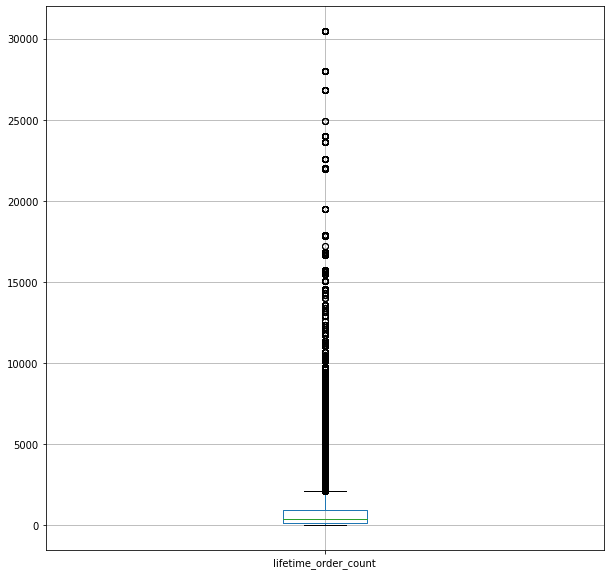

In [15]:
plt.figure(figsize = (10,10))
data_df[~np.isnan(data_df.lifetime_order_count)][['lifetime_order_count']][data_df[~np.isnan(data_df.lifetime_order_count)][['lifetime_order_count']] <= x].boxplot(column = ['lifetime_order_count'])

In [16]:
x = data_df[~np.isnan(data_df.undelivered_orders)].undelivered_orders.quantile(1)

<AxesSubplot:>

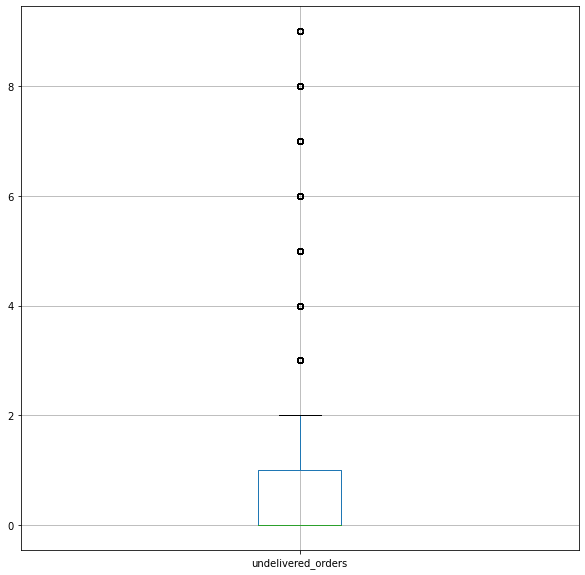

In [17]:
plt.figure(figsize = (10,10))
data_df[~np.isnan(data_df.undelivered_orders)][['undelivered_orders']][data_df[~np.isnan(data_df.undelivered_orders)][['undelivered_orders']] <= x].boxplot(column = ['undelivered_orders'])

In [18]:
data_df[~np.isnan(data_df.undelivered_orders)][['undelivered_orders']].value_counts()

undelivered_orders
0.0                   232686
1.0                   118103
2.0                    50582
3.0                    20011
4.0                     7733
5.0                     1851
6.0                      932
7.0                      600
8.0                      105
9.0                       56
dtype: int64

In [19]:
#delivered_orders
data_df[~np.isnan(data_df.delivered_orders)][['delivered_orders']].value_counts()

delivered_orders
6.0                 3798
4.0                 3698
5.0                 3697
7.0                 3645
3.0                 3528
                    ... 
562.0                 12
420.0                 10
553.0                  9
522.0                  8
482.0                  5
Length: 504, dtype: int64

In [20]:
x = data_df[~np.isnan(data_df.delivered_orders)].delivered_orders.quantile(1)

<AxesSubplot:>

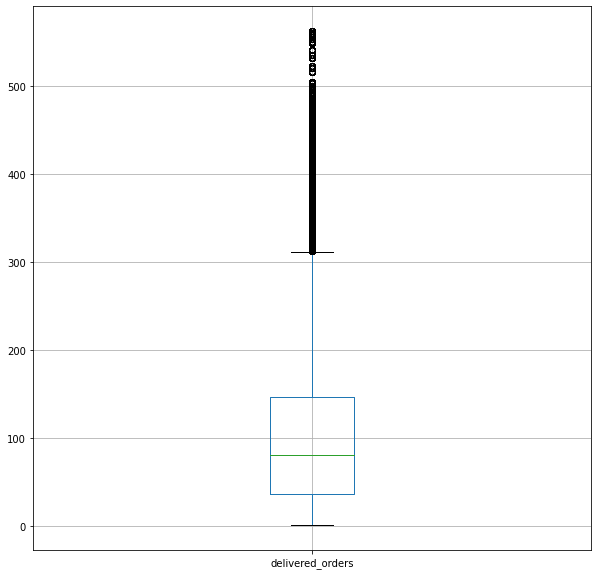

In [21]:
plt.figure(figsize = (10,10))
data_df[~np.isnan(data_df.delivered_orders)][['delivered_orders']][data_df[~np.isnan(data_df.delivered_orders)][['delivered_orders']] <= x].boxplot(column = ['delivered_orders'])

<AxesSubplot:>

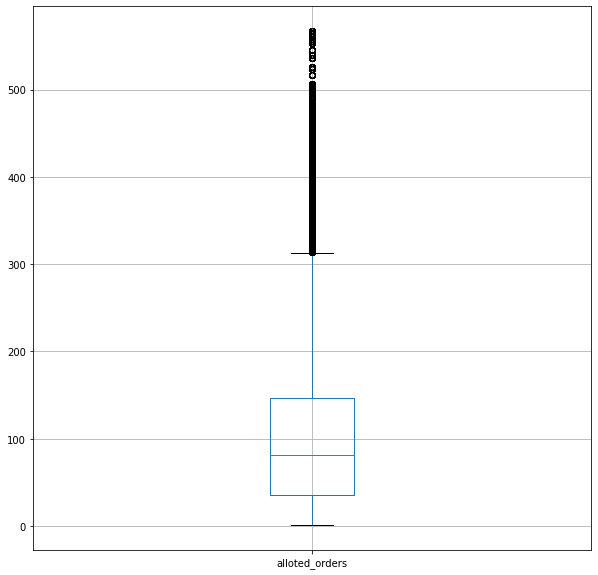

In [22]:
#alloted_orders
x = data_df[~np.isnan(data_df.alloted_orders)].alloted_orders.quantile(1)
plt.figure(figsize = (10,10))
data_df[~np.isnan(data_df.alloted_orders)][['alloted_orders']][data_df[~np.isnan(data_df.alloted_orders)][['alloted_orders']] <= x].boxplot(column = ['alloted_orders'])

In [23]:
data_df.order_time

0         2021-01-26 02:21:35
1         2021-01-26 02:33:16
2         2021-01-26 02:39:49
3         2021-01-26 02:47:53
4         2021-01-26 03:06:30
                 ...         
449995    2021-02-06 10:03:16
449996    2021-02-06 10:03:17
449997    2021-02-06 10:03:18
449998    2021-02-06 10:03:19
449999    2021-02-06 10:03:24
Name: order_time, Length: 450000, dtype: object

In [24]:
pd.to_datetime(data_df.order_time , yearfirst =True)

0        2021-01-26 02:21:35
1        2021-01-26 02:33:16
2        2021-01-26 02:39:49
3        2021-01-26 02:47:53
4        2021-01-26 03:06:30
                 ...        
449995   2021-02-06 10:03:16
449996   2021-02-06 10:03:17
449997   2021-02-06 10:03:18
449998   2021-02-06 10:03:19
449999   2021-02-06 10:03:24
Name: order_time, Length: 450000, dtype: datetime64[ns]

In [25]:
pd.to_datetime(data_df.order_time , yearfirst =True).dt.day_name().value_counts()

Friday       83548
Thursday     80468
Wednesday    80462
Tuesday      78965
Saturday     49470
Sunday       39254
Monday       37833
Name: order_time, dtype: int64

In [26]:
pd.to_datetime(test_df.order_time , yearfirst =True).dt.day_name().value_counts()

Tuesday     41189
Monday      39256
Sunday      37905
Saturday    26494
Name: order_time, dtype: int64

In [27]:
def get_features(df):
    df = df[['order_time', 'order_id','first_mile_distance', 'last_mile_distance','alloted_orders', 'delivered_orders', 'undelivered_orders','lifetime_order_count']]
    days = ['Monday' , 'Saturday' , 'Sunday' , 'Thursday' , 'Tuesday', 'Wednesday' ,'Friday']
    for i in df.columns[2:]:
        #print(i)
        #print(df[[i]][~np.isnan(df[i])][i].quantile(0.5))
        df[[i]] = df[[i]].fillna(df[[i]][~np.isnan(df[i])][i].quantile(0.5) )
    ## Processing Date 
    df.order_time = pd.to_datetime(df.order_time ,yearfirst =True)
    df['Day_of_the_week'] = df.order_time.dt.day_name()
    df['Hour'] = df.order_time.dt.hour
    df.drop(columns = ['order_time'] ,inplace =True)
    df = pd.concat([df,pd.get_dummies(df['Day_of_the_week']).astype(int)] ,axis = 1)
    df.drop(columns = ['Day_of_the_week'] ,inplace = True)
    for i in days:
        if i not in df.columns:
            df[i] = 0
    df = df[['order_id','first_mile_distance', 'last_mile_distance','alloted_orders', 'delivered_orders', 'undelivered_orders','lifetime_order_count','Hour' ,'Monday' , 'Saturday' , 'Sunday' , 'Thursday' , 'Tuesday', 'Wednesday' ]]        
    df = reduce_mem_usage(df)
    return df

In [28]:
X ,y = get_features(data_df) , data_df[['cancelled']]
test_df = get_features(test_df)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Memory usage of dataframe is 30.90 MB
Memory usage after optimization is: 12.87 MB
Decreased by 58.3%


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Memory usage of dataframe is 9.95 MB
Memory usage after optimization is: 4.14 MB
Decreased by 58.3%


In [29]:
X.shape ,y.shape ,test_df.shape

((450000, 14), (450000, 1), (144844, 14))

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              450000 non-null  int32  
 1   first_mile_distance   450000 non-null  float16
 2   last_mile_distance    450000 non-null  float16
 3   alloted_orders        450000 non-null  float16
 4   delivered_orders      450000 non-null  float16
 5   undelivered_orders    450000 non-null  float16
 6   lifetime_order_count  450000 non-null  float16
 7   Hour                  450000 non-null  int16  
 8   Monday                450000 non-null  int16  
 9   Saturday              450000 non-null  int16  
 10  Sunday                450000 non-null  int16  
 11  Thursday              450000 non-null  int16  
 12  Tuesday               450000 non-null  int16  
 13  Wednesday             450000 non-null  int16  
dtypes: float16(6), int16(7), int32(1)
memory usage: 12.9

In [31]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   cancelled  450000 non-null  int16
dtypes: int16(1)
memory usage: 879.0 KB


In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144844 entries, 0 to 144843
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              144844 non-null  int32  
 1   first_mile_distance   144844 non-null  float16
 2   last_mile_distance    144844 non-null  float16
 3   alloted_orders        144844 non-null  float16
 4   delivered_orders      144844 non-null  float16
 5   undelivered_orders    144844 non-null  float16
 6   lifetime_order_count  144844 non-null  float16
 7   Hour                  144844 non-null  int16  
 8   Monday                144844 non-null  int16  
 9   Saturday              144844 non-null  int16  
 10  Sunday                144844 non-null  int16  
 11  Thursday              144844 non-null  int16  
 12  Tuesday               144844 non-null  int16  
 13  Wednesday             144844 non-null  int16  
dtypes: float16(6), int16(7), int32(1)
memory usage: 4.1 

In [33]:
X.head(10)

,order_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,Hour,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,556753,1.566406,2.650391,46.0,46.0,0.0,621.0,2,0,0,0,0,1,0
1,556754,2.521484,2.759766,8.0,8.0,0.0,105.0,2,0,0,0,0,1,0
2,556755,2.207031,4.800781,1.0,1.0,0.0,66.0,2,0,0,0,0,1,0
3,556756,2.189453,6.378906,1.0,1.0,0.0,127.0,2,0,0,0,0,1,0
4,556757,2.787109,4.011719,34.0,34.0,0.0,84.0,3,0,0,0,0,1,0
5,556758,2.482422,5.179688,296.0,294.0,2.0,1506.0,3,0,0,0,0,1,0
6,556759,2.808594,3.400391,45.0,45.0,0.0,1460.0,3,0,0,0,0,1,0
7,556760,0.025681,0.160034,54.0,53.0,1.0,270.0,3,0,0,0,0,1,0
8,556761,2.443359,2.859375,29.0,29.0,0.0,955.0,3,0,0,0,0,1,0
9,556762,2.878906,2.609375,81.0,81.0,0.0,1.0,3,0,0,0,0,1,0


In [34]:
test_df.head(10)

,order_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,Hour,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,130231,1.658203,4.539062,216.0,215.0,1.0,747.0,10,0,1,0,0,0,0
1,130232,2.070312,5.839844,52.0,52.0,0.0,75.0,10,0,1,0,0,0,0
2,130233,1.388672,0.990234,289.0,289.0,0.0,2214.0,10,0,1,0,0,0,0
3,130234,1.904297,2.589844,125.0,122.0,3.0,1020.0,10,0,1,0,0,0,0
4,130235,0.827637,0.939941,352.0,350.0,2.0,7284.0,10,0,1,0,0,0,0
5,130237,0.879883,5.488281,5.0,5.0,0.0,261.0,10,0,1,0,0,0,0
6,130236,0.601074,0.970215,59.0,58.0,1.0,889.0,10,0,1,0,0,0,0
7,130238,1.467773,1.450195,178.0,178.0,0.0,348.0,10,0,1,0,0,0,0
8,130239,1.833984,1.230469,30.0,30.0,0.0,87.0,10,0,1,0,0,0,0
9,130240,2.279297,2.419922,81.0,81.0,0.0,1470.0,10,0,1,0,0,0,0


In [36]:
from sklearn.manifold import TSNE

In [37]:
X[:5000].shape

(5000, 14)

In [38]:
coor = TSNE(2).fit_transform(X[:50000])
#sns.scatterplot()

In [39]:
y[:50000][y[:50000]['cancelled'] == 1].shape

(550, 1)

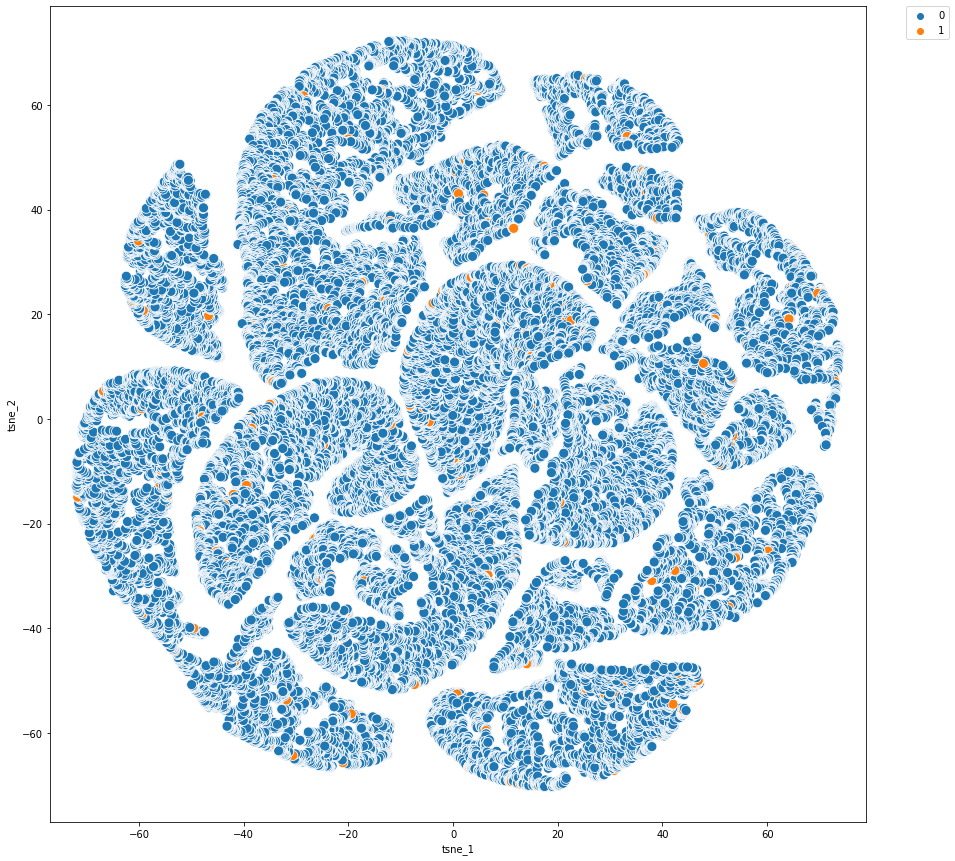

In [40]:
tsne_result_df = pd.DataFrame({'tsne_1': coor[:,0], 'tsne_2': coor[:,1], 'label': y[:50000]['cancelled'].tolist()})
fig, ax = plt.subplots(1)
fig.set_figheight(15)
fig.set_figwidth(15)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=100)
lim = (coor.min()-5, coor.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [36]:
Length = X.shape[0]
X_train ,y_train = X[:int((1-TEST_SPLIT_RATIO)*Length)] , y[:int((1-TEST_SPLIT_RATIO)*Length)]
X_test , y_test = X[int((1-TEST_SPLIT_RATIO)*Length):] ,y[int((1-TEST_SPLIT_RATIO)*Length):]

In [37]:
X_train[:1]

,order_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,Hour,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,556753,1.566406,2.650391,46.0,46.0,0.0,621.0,2,0,0,0,0,1,0


In [38]:
X_train[-1:]

,order_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,Hour,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
359999,202971,1.706055,4.171875,174.0,172.0,2.0,2392.0,7,0,0,0,1,0,0


In [39]:
X_test[:1]

,order_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,Hour,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
360000,202972,0.801758,3.679688,205.0,202.0,3.0,814.0,7,0,0,0,1,0,0


In [40]:
##underfitting
clf = LogisticRegression(random_state=SEED).fit(X_train, y_train)
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) , roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.5834576850320927 0.5525456450748514


In [47]:
##overfitting --- STill better than Logistic regression
clf = RandomForestClassifier(random_state=SEED).fit(X_train, y_train)
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) , roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.6113607303976768 0.9999999993344187


In [47]:
#param_grid = {
    
#    'n_estimators':[100 ,500 ,1000],
#    'max_depth' : [10 ,50 ,100],
#    'min_samples_split' : [5,10,15],
#    'min_samples_leaf' : [2,5,10],
#    'max_leaf_nodes' : [10 ,20,100]
#}
param_grid = {
    
    'n_estimators':[60 ,100 ,200],
    'max_depth' : [5 ,10 ,20],
    'min_samples_split' : [5],
    'min_samples_leaf' : [2],
    'max_leaf_nodes' : [10 ,20,30]
}

In [48]:
model = GridSearchCV(RandomForestClassifier(random_state=SEED) ,param_grid ,scoring='roc_auc' ,n_jobs =-1,verbose =2)
model.fit(X_train[:50000] ,y_train[:50000])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.5s
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt

GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'max_leaf_nodes': [10, 20, 30],
                         'min_samples_leaf': [2], 'min_samples_split': [5],
                         'n_estimators': [60, 100, 200]},
             scoring='roc_auc', verbose=2)

In [50]:
model.best_params_

{'max_depth': 5,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 60}

In [60]:
##params = {'max_depth': 10,'max_leaf_nodes': 20,'min_samples_leaf': 2,'min_samples_split': 5,'n_estimators': 100}
params = {'max_depth': 5,'max_leaf_nodes': 20,'min_samples_leaf': 10,'min_samples_split': 10,'n_estimators': 200}

In [61]:
clf = RandomForestClassifier(random_state=SEED ,**params).fit(X_train, y_train)
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) , roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


0.6536012911024423 0.6948716301216737


In [59]:
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) , roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))

0.6536012911024423 0.6948716301216737


Preparing for submission

In [62]:
clf = RandomForestClassifier(random_state=SEED ,**params).fit(X, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [63]:
X_test.head()

,order_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,Hour,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
360000,202972,0.801758,3.679688,205.0,202.0,3.0,814.0,7,0,0,0,1,0,0
360001,202973,0.441650,1.169922,142.0,140.0,2.0,2218.0,7,0,0,0,1,0,0
360002,202974,0.745605,5.960938,78.0,77.0,1.0,164.0,7,0,0,0,1,0,0
360003,202975,1.549805,4.761719,71.0,71.0,0.0,102.0,7,0,0,0,1,0,0
360004,202976,0.445068,4.929688,76.0,75.0,1.0,128.0,7,0,0,0,1,0,0


In [64]:
test_df.head()

,order_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,undelivered_orders,lifetime_order_count,Hour,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,130231,1.658203,4.539062,216.0,215.0,1.0,747.0,10,0,1,0,0,0,0
1,130232,2.070312,5.839844,52.0,52.0,0.0,75.0,10,0,1,0,0,0,0
2,130233,1.388672,0.990234,289.0,289.0,0.0,2214.0,10,0,1,0,0,0,0
3,130234,1.904297,2.589844,125.0,122.0,3.0,1020.0,10,0,1,0,0,0,0
4,130235,0.827637,0.939941,352.0,350.0,2.0,7284.0,10,0,1,0,0,0,0


In [68]:
out = clf.predict_proba(test_df)[:,1]

In [75]:
out_df = pd.DataFrame({'cancelled' : out} , index = test_df.order_id)

In [76]:
out_df.head()

,cancelled
order_id,
130231,0.009612
130232,0.011969
130233,0.009558
130234,0.010142
130235,0.009570


In [77]:
out_df.reset_index(inplace =True)

In [78]:
out_df.head()

,order_id,cancelled
0,130231,0.009612
1,130232,0.011969
2,130233,0.009558
3,130234,0.010142
4,130235,0.009570


In [79]:
out_df.shape

(144844, 2)

In [80]:
out_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144844 entries, 0 to 144843
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   order_id   144844 non-null  int64  
 1   cancelled  144844 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.2 MB


In [82]:
out_df.to_csv('/kaggle/working/submission.csv' ,index =False)

In [72]:
sample_df = pd.read_csv('/kaggle/input/cascade-cup-22/sample_submission.csv')

In [73]:
sample_df.head()

,order_id,cancelled
0,130231,0
1,130232,0
2,130233,0
3,130234,0
4,130235,0


In [74]:
sample_df.shape

(144844, 2)

In [81]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144844 entries, 0 to 144843
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   order_id   144844 non-null  int64
 1   cancelled  144844 non-null  int64
dtypes: int64(2)
memory usage: 2.2 MB


In [84]:
out_df.columns #'cancelled' 'order_id'

Index(['order_id', 'cancelled'], dtype='object')